# Lecho fijo NINA
Basado (*adaptado/copiado*) en un paper de *Santiago Ortiz-Laverde, Camilo Rengifo, Martha Cobo, y Manuel Figueredo*.  
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7820488/#sec2.4.1.2  
El reactor se modela como uno "rectangular" plano, osea de profundidad infinita.  
Se puede modelar como un cilindro 3D pero muy costoso computacionalmente.  
O se puede modelar con las ecuaciones dadas en coordenadas cilíndricas, pero 2D (tengo que re-escribir los balances para esto, ya que actualmente son los balances en cartesianas genéricos, osea para diferenciales de volumen dx.dy.dz(.

In [31]:
from fenics import *
import numpy as np

import math as mt

In [47]:
# Time-stepping
t = 0.0
tf = 1.2                    # Final time, sec
num_steps = 100              # Number of time steps
delta_t = tf / num_steps     # Time step size, sec
dt = Constant(delta_t)

PBR_L = 1       # Reactor length, m
PBR_R = 0.05    # Reactor radius, m

mesh_elements_ratio=128

In [44]:
from mshr import *
from dolfin import Mesh, File, MeshFunction, Point, BoundaryMesh, SubDomain, plot, File

#cylinder = Cylinder(Point(0, 0, 0), Point(0, 0, PBR_L), PBR_R, PBR_R) #Cilindro (muy costoso computacionalmente)
#geometry = cylinder                                                   #Con un mesh ratio mayor a 64 ya mi ram no da...
#mesh = generate_mesh(geometry, mesh_elements_ratio)
#File("mesh/mesh.pvd") << mesh

class boundary(SubDomain): #General
    def inside(self, x, on_boundary):
        return on_boundary
class top_side(SubDomain): #1
    def inside(self, x, on_boundary):
        return near(x[1],PBR_L)
class bottom_side(SubDomain): #2
    def inside(self, x, on_boundary):
        return near(x[1],0)
class left_side(SubDomain): #3
    def inside(self, x, on_boundary):
        return near(x[0],0)    
class right_side(SubDomain): #3
    def inside(self, x, on_boundary):
        return near(x[0],PBR_R)
class pared_cilindro(SubDomain): #3
    def inside(self, x, on_boundary):
        return np.sqrt(x[0]**2+x[1]**2)==PBR_R-1e-8

mesh = generate_mesh(Rectangle(Point(0, 0), Point(PBR_R, PBR_L), ), mesh_elements_ratio)
boundary_markers = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
#surface_markers = MeshFunction("size_t", mesh, mesh.topology().dim(), 0)
top_side().mark(boundary_markers, 1)
bottom_side().mark(boundary_markers, 2)
left_side().mark(boundary_markers, 3)
right_side().mark(boundary_markers, 3)

#Caso cilindro 3D #inestable # no resuelve # costoso
#pared_cilindro().mark(boundary_markers, 3)

#File("mesh/mesh.pvd") << mesh
#File("mesh/surface_marker.pvd") << surface_markers
#File("mesh/boundary_marker.pvd") << boundary_markers #para chequear boundaries

Wallboundary_id = 3
Inletboundary_id = 2

#plot(mesh)

In [45]:
# Define function spaces for PDEs variational formulation.
P1 = FiniteElement('P', mesh.ufl_cell(), 1)  # Lagrange 1-order polynomials family
element = MixedElement([P1, P1, P1, P1])
V = FunctionSpace(mesh, element)

In [46]:
# Splitting test and trial functions
v_A, v_B, v_C, v_T = TestFunctions(V)  # Test functions
u = Function(V)
u_A, u_B, u_C, u_T = split(u)          # Trial functions, time step = n+1
u_n = Function(V)                      # Trial functions, time step = n
_3u_n = Function(V)

# Retrieve boundaries marks for Robin boundary conditions.
ds_in = Measure("ds", domain=mesh,
                subdomain_data=boundary_markers, subdomain_id=Inletboundary_id)
ds_wall = Measure("ds", domain=mesh,
                  subdomain_data=boundary_markers, subdomain_id=Wallboundary_id)

"""Initial values (t == 0.0)"""
CAo = Constant(0.0)          # Initial composition for A
CBo = Constant(0.0)          # Initial composition for A
CCo = Constant(0.0)          # Initial composition for A
To = Constant(625.15)        # Initial packed-bed Temperature
Twall = Constant(625.15)    # Initial wall temperature
    
# Frontera Dirichlet para 0, Neumann (derivada=constante=0 en este caso) para Largo
#bc_A = DirichletBC(V.sub(0), CAo, DirichletBoundary)
#bc_B = DirichletBC(V.sub(1), CBo, DirichletBoundary)
#bc_C = DirichletBC(V.sub(2), CCo, DirichletBoundary)
#bc_T = DirichletBC(V.sub(3), To, DirichletBoundary)
#bcs=[bc_A,bc_B,bc_C,bc_T]

u_0 = Expression(('CA_init', 'CB_init', 'CC_init', 'T_init'),
                 degree=0, CA_init=CAo, CB_init=CBo, CC_init=CCo, T_init=To)
u_n = interpolate(u_0, V)
u_An, u_Bn, u_Cn, u_Tn = split(u_n)

# Define expressions used in variational forms
R = Constant(8.314)          # Gas constant

# Velocity vector over axial coordinate.
Vz = Constant((4.0*1.6)/(3.14159*np.power(0.0254, 2)*3600.0))
w = as_vector([0.0, Vz*3]) #2D
#w = as_vector([0.0, 0.0, Vz]) #3D (cilindro) #Inestable, dificil que resuelva

"""Inlet values"""
PA_in = Constant(0.011e5)    # Inlet pressure of A (Limiting reagent)
PB_in = Constant(0.211e5)    # Inlet pressure of B  (Excess reagent)
PC_in = Constant(0.0)        # Inlet pressure of C  (Product)

T_in = Constant(625.15)      # Reageants inlet Temperature
CA_in = PA_in/(R*T_in)       # Inlet composition of A,
CB_in = PB_in/(R*T_in)       # Inlet composition of B,
CC_in = PC_in/(R*T_in)       # Inlet composition of B,
Tcool_in = Constant(625.15)  # Coolant inlet Temperature

"""Transport properties"""
eps = Constant(0.35)         # epsilon
knt = 0.6                    # Average Conductivity R-Z
D = 0.01                     # Average diffusivity R-Z

"""Kinetic parameters"""
alfa = Constant(19.837)
beta = Constant(13636.0)
Uc1 = Constant(3.60E+10)
deltaH = Constant(-307000.0*4.183)
rob = Constant(1300.0)

"""Stoichiometry coefficients"""
cofA = Constant(-1.0)
cofB = Constant(-3.0)
cofC = Constant(1.0)

"""Coolant properties"""
rof = Constant(1.293)
cpf = Constant(992.0)
hw = Constant(96.0)          # Wall heat transfer coefficient,

""" Cooling Jacket model """
Length = Constant(3.0)
radius = Constant(0.0127)
A = 2.0*mt.pi*radius*Length
fw = Constant(0.1)
Cpw = Constant(4200.0)
roW = Constant(1000.0)
Vw = Constant(3.0*(np.power(0.0254, 2))*(4.0-(np.power(mt.pi, 2))/4.0))
Denom = ((roW*Vw*Cpw)/dt + fw*Cpw + hw*A*Length)

def Kinetic_oxy(Temperature):
    """mathematical expression of
       kinetic temperature-dependent constant"""
    k_oxy = exp(alfa) * exp(-beta/Temperature)
    return k_oxy

In [48]:
# Variational problem definition

F_A = ((u_A - u_An)/dt)*v_A*dx + dot(w, grad(u_A))*v_A*dx + \
     eps*D*dot(grad(u_A), grad(v_A))*dx - \
     cofA*rob*Kinetic_oxy(u_Tn)*u_A*u_B*(pow(R*u_T, 2)/Uc1)*v_A*dx + \
     Vz*(u_A - CA_in)*v_A*ds_in

F_B = ((u_B - u_Bn)/dt)*v_B*dx + dot(w, grad(u_B))*v_B*dx + \
     eps*D*dot(grad(u_B), grad(v_B))*dx - \
     cofB*rob*Kinetic_oxy(u_Tn)*u_A*u_B*(pow(R*u_T, 2)/Uc1)*v_B*dx + \
     Vz*(u_B - CB_in)*v_B*ds_in

F_C = ((u_C - u_Cn)/dt)*v_C*dx + dot(w, grad(u_C))*v_C*dx + \
     eps*D*dot(grad(u_C), grad(v_C))*dx - \
     cofC*rob*Kinetic_oxy(u_Tn)*u_A*u_B*(pow(R*u_T, 2)/Uc1)*v_C*dx + \
     Vz*(u_C - CC_in)*v_C*ds_in

F_T = (rof*cpf*(u_T - u_Tn)/dt)*v_T*dx + \
      rof*cpf*dot(w, grad(u_T))*v_T*dx + \
      knt*dot(grad(u_T), grad(v_T))*dx + \
      deltaH*rob*Kinetic_oxy(u_Tn)*u_A*u_B*(pow(R*u_T, 2)/Uc1)*v_T*dx + \
      (rof*cpf*Vz)*(u_T - T_in)*v_T*ds_in + \
      hw*(u_T - Twall)*v_T*ds_wall

F = F_A + F_B + F_C + F_T

In [51]:
#Formato VTK
vtkfile_A = File('solucion_transitorio/sol_CA.pvd')
vtkfile_B = File('solucion_transitorio/sol_CB.pvd')
vtkfile_C = File('solucion_transitorio/sol_CC.pvd')
vtkfile_T = File('solucion_transitorio/sol_T.pvd')
PETScOptions.set("-mat_mumps_cntl_1", 0.05) 
for n in range(num_steps):
    print('{} out of {}'.format(n, num_steps))
    t += delta_t  # Update current time

    # Solve variational problem for time step
    solve(F == 0, u, solver_parameters={"newton_solver": {
            "relative_tolerance": 1e-6,
            "maximum_iterations": 10}})
    print('solver done')

    # Save solution to files for visualization and data postprocessing
    _u_A, _u_B, _u_C, _u_T = u_n.split()
    vtkfile_A << (_u_A, t)
    vtkfile_B << (_u_B, t)
    vtkfile_C << (_u_C, t)
    vtkfile_T << (_u_T, t)

    Uvector = 3*as_backend_type(u_n.vector()).get_local()
    _3u_n.vector().set_local(Uvector)
    _3u_A, _3u_B, _3u_C, _3u_T = _3u_n.split()
    _u_D = _3u_C


    u_n.assign(u)
print("Done")

0 out of 100
solver done
1 out of 100
solver done
2 out of 100
solver done
3 out of 100
solver done
4 out of 100
solver done
5 out of 100
solver done
6 out of 100
solver done
7 out of 100
solver done
8 out of 100
solver done
9 out of 100
solver done
10 out of 100
solver done
11 out of 100
solver done
12 out of 100
solver done
13 out of 100
solver done
14 out of 100
solver done
15 out of 100
solver done
16 out of 100
solver done
17 out of 100
solver done
18 out of 100
solver done
19 out of 100
solver done
20 out of 100
solver done
21 out of 100
solver done
22 out of 100
solver done
23 out of 100
solver done
24 out of 100
solver done
25 out of 100
solver done
26 out of 100
solver done
27 out of 100
solver done
28 out of 100
solver done
29 out of 100
solver done
30 out of 100
solver done
31 out of 100
solver done
32 out of 100
solver done
33 out of 100
solver done
34 out of 100
solver done
35 out of 100
solver done
36 out of 100
solver done
37 out of 100
solver done
38 out of 100
solver d

Último perfil para A a lo largo de r y z


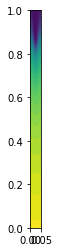

In [52]:
print("Último perfil para A a lo largo de r y z")
plot(_u_A)

## OJO
Ejecutar los bloques de abajo puede llegar a hacer que no se pueda graficar más con el plot "nativo" de FEniCS (como para generar el gráfico de arriba).

In [9]:
z=0.75
CR=[]
CA=[]
CB=[]
CC=[]
CT=[]
for r in np.linspace(0,PBR_R,100):
    CR.append(r)
    CA.append(_u_A(r,z))
    CB.append(_u_B(r,z))
    CC.append(_u_C(r,z))
    CT.append(_u_T(r,z))

<IPython.core.display.Javascript object>


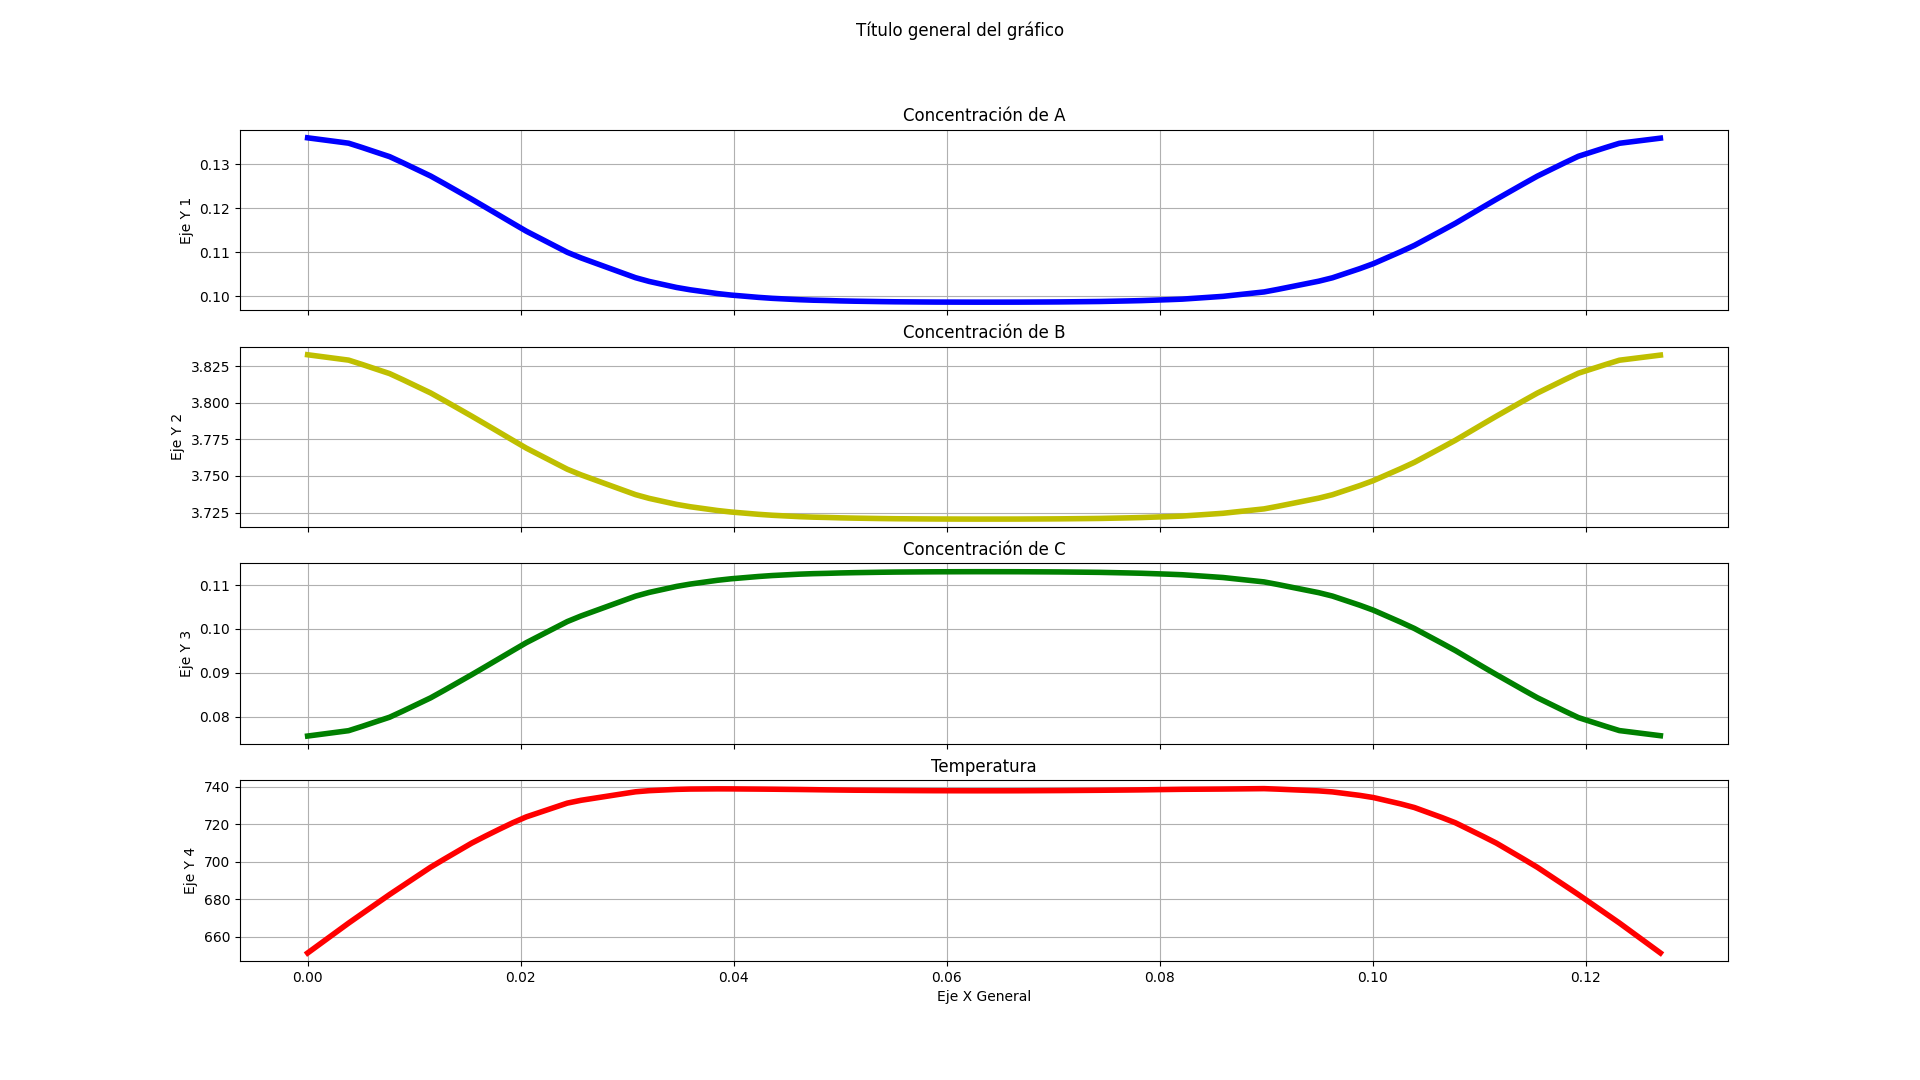

Text(0.5, 1.0, 'Temperatura')

In [11]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion
#plt.plot(CA)
#plt.plot(CC)
X=CR
Y1=CA
Y2=CB
Y3=CC
Y4=CT
fig, axs = plt.subplots(4,sharex=True,figsize=(19.20,10.80)) #equivale a 1920x1080
plt.xlabel("Eje X General")
fig.suptitle("Título general del gráfico")

axs[0].set(ylabel="Eje Y 1")
axs[0].plot(X, Y1,linewidth=4,color='b')                   #gráfico de líneas
axs[0].grid() #grilla
#axs[0].set_xlim([2002, 2018]) #opcional definir rango para X, aplica a los 3 gráficos en conjunto
axs[0].set_title('Concentración de A')

axs[1].set(ylabel="Eje Y 2")
axs[1].plot(X, Y2,linewidth=4,color='y')
axs[1].grid()
axs[1].set_title('Concentración de B')

axs[2].set(ylabel="Eje Y 3")
axs[2].plot(X, Y3,linewidth=4,color='g')
axs[2].grid()
axs[2].set_title('Concentración de C')

axs[3].set(ylabel="Eje Y 4")
axs[3].plot(X, Y4,linewidth=4,color='r')
axs[3].grid()
axs[3].set_title('Temperatura')

In [12]:
%matplotlib notebook
plt.ion
from mpl_toolkits import mplot3d
CR=[]
CZ=[]
CA=[]
CB=[]
CC=[]
CT=[]
for r in np.linspace(0,PBR_R,100):
    for z in np.linspace(0,PBR_L,100):
        CR.append(r)
        CZ.append(z)
        CA.append(_u_A(r,z))
        CB.append(_u_B(r,z))
        CC.append(_u_C(r,z))
        CT.append(_u_T(r,z))
CR=np.array(CR)
CZ=np.array(CZ)
CA=np.array(CA)
CB=np.array(CB)
CC=np.array(CC)
CT=np.array(CT)

<IPython.core.display.Javascript object>


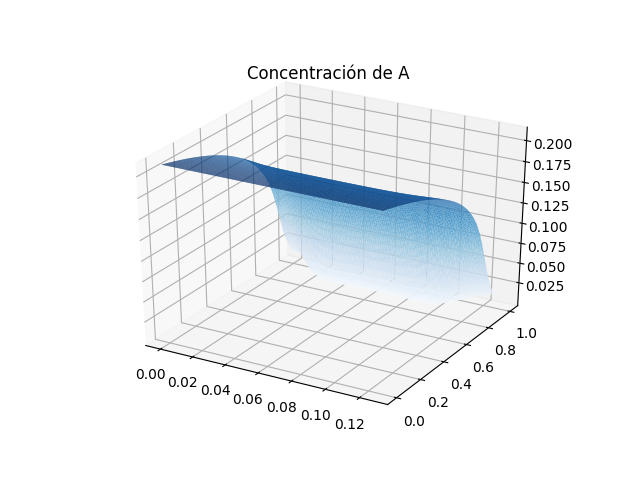

In [13]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_trisurf(CR,CZ,CA, cmap=plt.cm.Blues)
ax.set_title('Concentración de A')
plt.show()

<IPython.core.display.Javascript object>


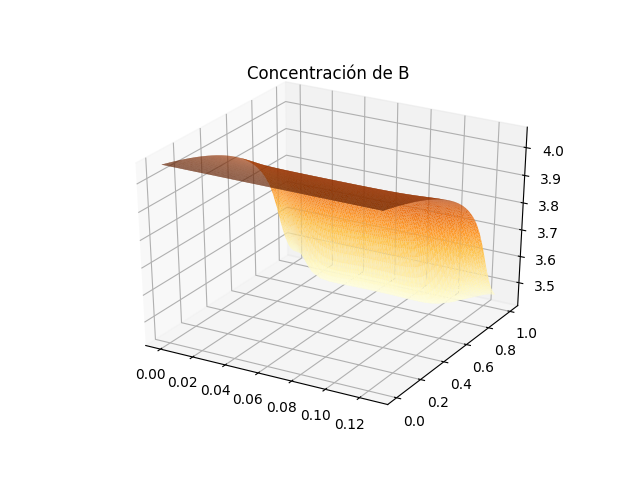

In [14]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_trisurf(CR,CZ,CB, cmap=plt.cm.YlOrBr)
ax.set_title('Concentración de B')
plt.show()

<IPython.core.display.Javascript object>


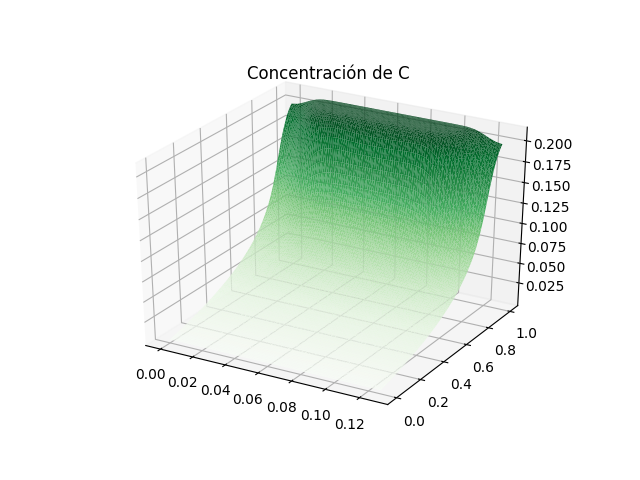

In [15]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_trisurf(CR,CZ,CC, cmap=plt.cm.Greens)
ax.set_title('Concentración de C')
plt.show()

<IPython.core.display.Javascript object>


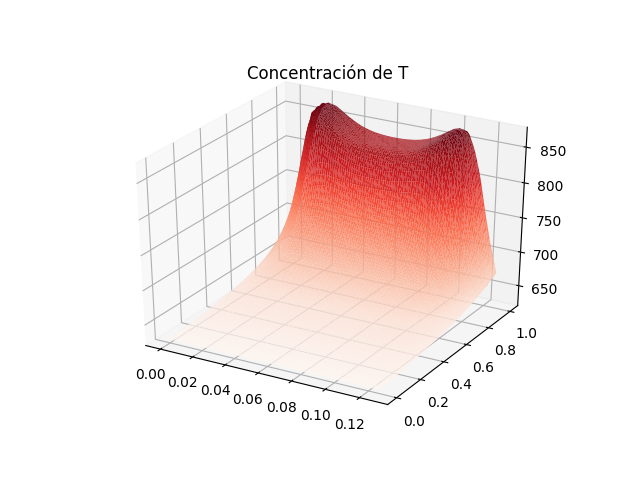

In [16]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_trisurf(CR,CZ,CT, cmap=plt.cm.Reds)
ax.set_title('Concentración de T')
plt.show()

In [17]:
#Resolución guardando en xdmf -> requiere borrar los resultados anteriores, sin mayores ventajas...
if 1==2: #para que no se ejecute
    fA_out = XDMFFile('solucion_transitorio/sol_A.xdmf')
    fB_out = XDMFFile('solucion_transitorio/sol_B.xdmf')
    fC_out = XDMFFile('solucion_transitorio/sol_C.xdmf')
    fT_out = XDMFFile('solucion_transitorio/sol_T.xdmf')
    for n in range(num_steps):
        print('{} out of {}'.format(n, num_steps))
        t += delta_t  # Update current time

        # Solve variational problem for time step
        solve(F == 0, u, solver_parameters={"newton_solver": {
                "relative_tolerance": 1e-6}, "newton_solver": {
                        "maximum_iterations": 10}})
        print('solver done')

        # Save solution to files for visualization and data postprocessing
        _u_A, _u_B, _u_C, _u_T = u_n.split()

        Uvector = 3*as_backend_type(u_n.vector()).get_local()
        _3u_n.vector().set_local(Uvector)
        _3u_A, _3u_B, _3u_C, _3u_T = _3u_n.split()
        _u_D = _3u_C

        fA_out.write_checkpoint(_u_A, "A", t,  XDMFFile.Encoding.HDF5, True)
        fB_out.write_checkpoint(_u_B, "B", t,  XDMFFile.Encoding.HDF5, True)
        fC_out.write_checkpoint(_u_C, "C", t,  XDMFFile.Encoding.HDF5, True)
        fT_out.write_checkpoint(_u_T, "T", t,  XDMFFile.Encoding.HDF5, True)

        Uvector = 3*as_backend_type(u_n.vector()).get_local()
        _3u_n.vector().set_local(Uvector)
        _3u_A, _3u_B, _3u_C, _3u_T = _3u_n.split()
        _u_D = _3u_C


        u_n.assign(u)
    fA_out.close(); fB_out.close(); fC_out.close(); fT_out.close()
    print("Done")